# Differential Privacy <> TensorFlow for Data Scientist Salaries
https://www.tensorflow.org/responsible_ai/privacy/tutorials/classification_privacy

## Setup Packages

### Install TensorFlow

In [1]:
!pip install tensorflow
!pip install tensorflow-privacy

In [2]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import numpy as np

tf.get_logger().setLevel('ERROR')

import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

Instructions for updating:
non-resource variables are not supported in the long term


### Install Other Libraries

In [3]:
import datetime
from datetime import datetime

from numpy.random import RandomState
import pandas as pd
from sklearn import preprocessing

## Setup Data

### Categorize Salaries

<AxesSubplot:>

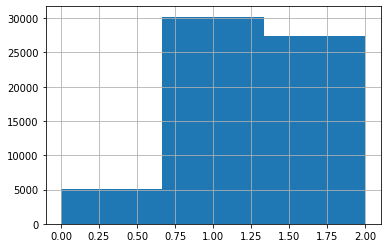

In [4]:
df = pd.read_csv('salaries.csv')

salary_ranges = [0,80000,200000,np.inf]
df['salaryrange'] = pd.cut(df.totalyearlycompensation, salary_ranges, labels=[0,1,2], include_lowest=True)

df['salaryrange'].hist(bins=len(salary_ranges) - 1)

In [5]:
df.salaryrange.value_counts()

1    30203
2    27429
0     5010
Name: salaryrange, dtype: int64

### Make All Values Into Integers

In [6]:
# encode timestamp into integers, by year and month
def timestamp_to_int(timestamp):
    dt_obj = datetime.strptime(timestamp.split(' ')[0], '%m/%d/%Y')
    return (100 * dt_obj.year) + (dt_obj.month)

df['timestamp'] = df['timestamp'].apply(timestamp_to_int)

# turn company names to lowercase and encode as integers
df['company'] = df['company'].apply(lambda t: str(t).lower())
df['company'] = pd.Categorical(pd.factorize(df['company'])[0])

# encode level as integer
df['level'] = pd.Categorical(pd.factorize(df['level'])[0])

# encode title as integer
df['title'] = pd.Categorical(pd.factorize(df['title'])[0])

# encode tag as integer
df['tag'] = pd.Categorical(pd.factorize(df['tag'])[0])

# encode gender as integer
df['gender'] = pd.Categorical(pd.factorize(df['gender'])[0])

# encode Race as integer
df['Race'] = pd.Categorical(pd.factorize(df['Race'])[0])

# encode Education as integer
df['Education'] = pd.Categorical(pd.factorize(df['Education'])[0])


### Remove Rows

In [7]:
df = df[df['gender'] != -1]
df = df[df['Education'] != -1]
df = df[df['Race'] != -1]

### Drop Columns

In [8]:
# make model predict without knowledge of the totalyearlycompensation
df.drop('totalyearlycompensation', axis=1, inplace=True)

# location information is already encoded as an integer in 'cityid'
df.drop('location', axis=1, inplace=True)

# make model predict without knowledge of the base salary
df.drop('basesalary', axis=1, inplace=True)

# 'otherdetails' column requires NLP to interpret
df.drop('otherdetails', axis=1, inplace=True)

# 'rowNumber' column is unnecessary
df.drop('rowNumber', axis=1, inplace=True)

# education information is entirely encoded in the 'Education' column already
df.drop('Masters_Degree', axis=1, inplace=True)
df.drop('Bachelors_Degree', axis=1, inplace=True)
df.drop('Doctorate_Degree', axis=1, inplace=True)
df.drop('Highschool', axis=1, inplace=True)
df.drop('Some_College', axis=1, inplace=True)

# race information is entirely encoded in the 'Race' column already
df.drop('Race_Asian', axis=1, inplace=True)
df.drop('Race_White', axis=1, inplace=True)
df.drop('Race_Two_Or_More', axis=1, inplace=True)
df.drop('Race_Black', axis=1, inplace=True)
df.drop('Race_Hispanic', axis=1, inplace=True)

### Training/Testing Data

In [9]:
drop_indices = np.random.choice(df.index, len(df.index) % 1250, replace=False)
df.drop(drop_indices, inplace=True)

rng = RandomState()

df_train = df.sample(frac=0.8, random_state=rng)
df_test = df.loc[~df.index.isin(df_train.index)]

In [10]:
train_data = df_train.loc[:, df_train.columns != 'salaryrange'].to_numpy()
test_data = df_test.loc[:, df_test.columns != 'salaryrange'].to_numpy()

train_labels = df_train['salaryrange'].to_numpy()
test_labels = df_test['salaryrange'].to_numpy()

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(salary_ranges) - 1)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(salary_ranges) - 1)

## Make Models

In [11]:
epochs = 7
batch_size = 250

l2_norm_clip = 1.4
noise_multiplier = 1.3
num_microbatches = 125
learning_rate = 0.2

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

### Baseline Model

In [12]:
model_base = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(len(salary_ranges) - 1, activation='softmax')
])

model_base.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model_base.build(train_data.shape)
model_base.summary()
model_base.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels), batch_size=batch_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  1920      
                                                                 
 dense_1 (Dense)             multiple                  8256      
                                                                 
 dense_2 (Dense)             multiple                  2080      
                                                                 
 dense_3 (Dense)             multiple                  99        
                                                                 
Total params: 12,355
Trainable params: 12,355
Non-trainable params: 0
_________________________________________________________________
Train on 17000 samples, validate on 4250 samples
Epoch 1/7
10500/17000 [=================>............] - ETA: 0s - loss: 0.9728 - acc: 0.5119

2022-05-10 17:00:57.009497: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


17000/17000 [==============================] - 0s 10us/sample - loss: 0.9413 - acc: 0.5564 - val_loss: 0.8660 - val_acc: 0.6487
Epoch 2/7
17000/17000 [==============================] - 0s 5us/sample - loss: 0.7906 - acc: 0.7170 - val_loss: 0.7024 - val_acc: 0.7631
Epoch 3/7
12000/17000 [====================>.........] - ETA: 0s - loss: 0.6711 - acc: 0.7647

/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


17000/17000 [==============================] - 0s 5us/sample - loss: 0.6548 - acc: 0.7705 - val_loss: 0.6022 - val_acc: 0.7901
Epoch 4/7
17000/17000 [==============================] - 0s 6us/sample - loss: 0.5868 - acc: 0.7875 - val_loss: 0.5542 - val_acc: 0.8005
Epoch 5/7
17000/17000 [==============================] - 0s 6us/sample - loss: 0.5564 - acc: 0.7868 - val_loss: 0.5293 - val_acc: 0.7979
Epoch 6/7
17000/17000 [==============================] - 0s 5us/sample - loss: 0.5356 - acc: 0.7862 - val_loss: 0.5189 - val_acc: 0.7889
Epoch 7/7
17000/17000 [==============================] - 0s 5us/sample - loss: 0.5250 - acc: 0.7835 - val_loss: 0.5174 - val_acc: 0.7984


In [13]:
model_base_loss, model_base_metric = model_base.evaluate(test_data, test_labels, batch_size=batch_size)
print(model_base_metric)

0.79835296


### DP Model

In [14]:
model_dp = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(len(salary_ranges) - 1, activation='softmax')
])

optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

model_dp.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_dp.build(train_data.shape)
model_dp.summary()
model_dp.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels), batch_size=batch_size)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             multiple                  1920      
                                                                 
 dense_5 (Dense)             multiple                  8256      
                                                                 
 dense_6 (Dense)             multiple                  2080      
                                                                 
 dense_7 (Dense)             multiple                  99        
                                                                 
Total params: 12,355
Trainable params: 12,355
Non-trainable params: 0
_________________________________________________________________


/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Train on 17000 samples, validate on 4250 samples
Epoch 1/7
17000/17000 [==============================] - 5s 298us/sample - loss: 0.9230 - acc: 0.5719 - val_loss: 0.8408 - val_acc: 0.7233
Epoch 2/7
17000/17000 [==============================] - 1s 54us/sample - loss: 0.7470 - acc: 0.7407 - val_loss: 0.6473 - val_acc: 0.7569
Epoch 3/7
17000/17000 [==============================] - 1s 62us/sample - loss: 0.6151 - acc: 0.7673 - val_loss: 0.5734 - val_acc: 0.7824
Epoch 4/7
17000/17000 [==============================] - 1s 62us/sample - loss: 0.5897 - acc: 0.7748 - val_loss: 0.5583 - val_acc: 0.7906
Epoch 5/7
17000/17000 [==============================] - 1s 63us/sample - loss: 0.5796 - acc: 0.7756 - val_loss: 0.5761 - val_acc: 0.7715
Epoch 6/7
17000/17000 [==============================] - 1s 69us/sample - loss: 0.5765 - acc: 0.7773 - val_loss: 0.5587 - val_acc: 0.7885
Epoch 7/7
17000/17000 [==============================] - 1s 63us/sample - loss: 0.5748 - acc: 0.7734 - val_loss: 0.5507 - 

In [15]:
model_dp_loss, model_dp_metric = model_dp.evaluate(test_data, test_labels, batch_size=batch_size)
print(model_dp_metric)

0.7877647


In [16]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-6)

DP-SGD with sampling rate = 1.47% and noise_multiplier = 1.3 iterated over 476 steps satisfies differential privacy with eps = 1.54 and delta = 1e-06.
The optimal RDP order is 13.0.


(1.5397192233591848, 13.0)